# UNet сегментация

## Kaggle датасет

In [1]:
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision import models

from skimage import data

from PIL import Image

from tqdm import trange, tqdm

from sklearn.model_selection import train_test_split

In [2]:
dataset_path = "/kaggle/input/minerals-creative-15kgenerated/minerals-creative-15k"
train_images_path = os.path.join(dataset_path, "images/train")
train_masks_path = os.path.join(dataset_path, "annotations/train")
test_images_path = os.path.join(dataset_path, "images/test")
test_masks_path = os.path.join(dataset_path, "annotations/test")

print("Train Images:", len(os.listdir(train_images_path)))
print("Train Masks:", len(os.listdir(train_masks_path)))
print("Test Images:", len(os.listdir(test_images_path)))
print("Test Masks:", len(os.listdir(test_masks_path)))

print("\nПримеры файлов (Train Images):", os.listdir(train_images_path)[:5])
print("Примеры файлов (Train Masks):", os.listdir(train_masks_path)[:5])

Train Images: 13500
Train Masks: 13500
Test Images: 1500
Test Masks: 1500

Примеры файлов (Train Images): ['bg_4_combo_837.png', 'bg_0_combo_863.png', 'bg_4_combo_1289.png', 'bg_4_combo_141.png', 'bg_1_combo_2164.png']
Примеры файлов (Train Masks): ['bg_4_combo_837.png', 'bg_0_combo_863.png', 'bg_4_combo_1289.png', 'bg_4_combo_141.png', 'bg_1_combo_2164.png']


✅ Изображение: (862, 862, 3), Маска: (862, 862), dtype: uint8


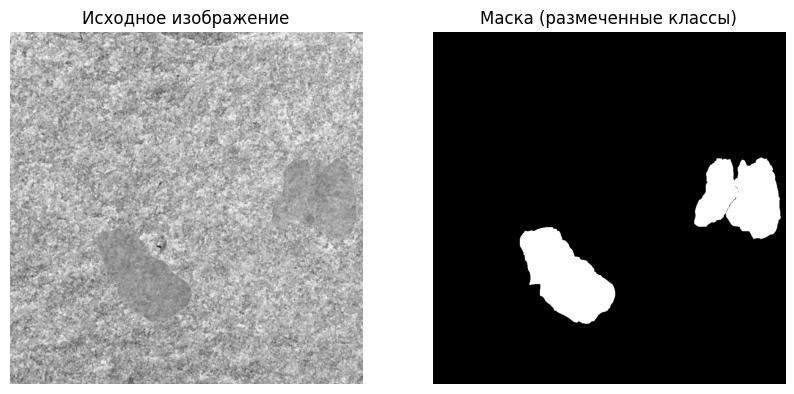

In [3]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

def visualize_sample(image_path, mask_path):
    if not os.path.exists(image_path):
        print(f"❌ Изображение не найдено: {image_path}")
        return
    if not os.path.exists(mask_path):
        print(f"❌ Маска не найдена: {mask_path}")
        return
    
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR → RGB

    mask = Image.open(mask_path).convert("L")  # Преобразуем в оттенки серого
    mask = np.array(mask)

    print(f"✅ Изображение: {image.shape}, Маска: {mask.shape}, dtype: {mask.dtype}")

    # Отображаем
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title("Исходное изображение")
    ax[0].axis("off")

    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("Маска (размеченные классы)")
    ax[1].axis("off")

    plt.show()

image_files = sorted(os.listdir(train_images_path))
mask_files = sorted(os.listdir(train_masks_path))

sample_image = image_files[0]  # Берем первое изображение

sample_mask = os.path.splitext(sample_image)[0] + ".png"

image_path = os.path.join(train_images_path, sample_image)
mask_path = os.path.join(train_masks_path, sample_mask)

visualize_sample(image_path, mask_path)


In [4]:
mask_files = sorted(os.listdir(train_masks_path))

all_classes = set()

for mask_file in mask_files:
    mask_path = os.path.join(train_masks_path, mask_file)
    mask = Image.open(mask_path)
    mask_array = np.array(mask)
    
    unique_classes = np.unique(mask_array)
    all_classes.update(unique_classes)

print(f"Общее количество уникальных классов: {len(all_classes)}")
print(f"Уникальные классы: {sorted(all_classes)}")

Общее количество уникальных классов: 2
Уникальные классы: [0, 1]


## PyTorch датасет и даталоадер

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import cv2
import numpy as np
from PIL import Image

class PlantSegDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, img_size=512):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_filenames = sorted(os.listdir(images_dir))  # Сортируем файлы, чтобы соответствовали
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        mask_filename = os.path.splitext(image_filename)[0] + ".png"
        image_path = os.path.join(self.images_dir, image_filename)
        mask_path = os.path.join(self.masks_dir, mask_filename)

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (self.img_size, self.img_size))  # Ресайз до 512x512
        image = image.astype(np.float32) / 255.0  # Нормализация [0,1]

        # Конвертируем изображение в три канала (копируем одно и то же изображение в 3 канала)
        image = np.stack([image, image, image], axis=-1)  # [H, W, 3]

        mask = Image.open(mask_path).convert("L")  # Преобразуем в оттенки серого
        mask = mask.resize((self.img_size, self.img_size), Image.NEAREST)  # Ресайз маски (NEAREST для классов)
        mask = np.array(mask, dtype=np.int64)  # Оставляем как int64 (классы)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # [H, W, C] → [C, H, W]
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

train_dataset = PlantSegDataset(train_images_path, train_masks_path, img_size=512)

sample_img, sample_mask = train_dataset[0]
print(f"Форма изображения: {sample_img.shape}")  # [3, 512, 512]
print(f"Форма маски: {sample_mask.shape}")        # [512, 512]
print(f"Классы в маске: {torch.unique(sample_mask)}")  # Проверяем, что классы от 0 до 114


Форма изображения: torch.Size([3, 512, 512])
Форма маски: torch.Size([512, 512])
Классы в маске: tensor([0, 1])


## Classic U-net
U-Net: Convolutional Networks for Biomedical Image Segmentation


<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" alt="drawing" width="800"/>


Перейдем к самой сети U-net - в ней не просто принимаем на вход изображение, сжимаем его, а потом разжимаем, но при это еще делим глобальные skip connection'ы (серые стрелки). Важно, чтобы все работало, чтобы выход слоя (начало стрелка) должен совпадать с входом слоя (остриё стрелки), поэтому надо соблюдать такую совместимость.

Посмотрим, какой размер идет на вход и какой получается на выходе. В нашем примере на вход 3 (канала) и размерность изображения (384, 512), а на выходе хотим маску, у которой будет 1 канал, а при этом этот 1 канал будет отвечать за 1 класс (в нашем случае датасет состоит из 1 класса - человек). Если было бы несколько классов, то на выходе было бы несколько каналов и выдавались, например, двухканальное бинарное изображение, где первый канал отвечал за человека, а второй за кота.

Implementation

https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

In [6]:
BATCH_SIZE = 8
NUM_WORKERS = 2

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)

batch_images, batch_masks = next(iter(train_loader))
print(f"Размер batch изображений: {batch_images.shape}")  # [B, 3, 512, 512]
print(f"Размер batch масок: {batch_masks.shape}")        # [B, 512, 512]

Размер batch изображений: torch.Size([8, 3, 512, 512])
Размер batch масок: torch.Size([8, 512, 512])


In [7]:
import torchvision.models.segmentation as segmentation
deeplab = segmentation.deeplabv3_resnet50(pretrained=True)
deeplab.backbone

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


IntermediateLayerGetter(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [11]:
import torch
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

backbone = deeplabv3_resnet50(pretrained=True).backbone

# Тестовый входной тензор (имитируем изображение 512x512 с 3 каналами)
x = torch.randn(1, 3, 512, 512)

s1 = backbone.conv1(x)  # После первого сверточного слоя
s1 = backbone.bn1(s1)  # После BatchNorm
s1 = backbone.relu(s1)  # После ReLU
s1 = backbone.maxpool(s1)  # После MaxPool
print(f"s1 (после maxpool): {s1.shape}")  #  (1, 64, 128, 128)

s2 = backbone.layer1(s1)
print(f"s2: {s2.shape}")  #  (1, 256, 128, 128)

s3 = backbone.layer2(s2)
print(f"s3: {s3.shape}")  #  (1, 512, 64, 64)

s4 = backbone.layer3(s3)
print(f"s4: {s4.shape}")  #  (1, 1024, 32, 32)

bottleneck = backbone.layer4(s4)
print(f"bottleneck: {bottleneck.shape}")  #  (1, 2048, 16, 16)


s1 (после maxpool): torch.Size([1, 64, 128, 128])
s2: torch.Size([1, 256, 128, 128])
s3: torch.Size([1, 512, 64, 64])
s4: torch.Size([1, 1024, 64, 64])
bottleneck: torch.Size([1, 2048, 64, 64])


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.segmentation import deeplabv3_resnet50

class UNetDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        # Адаптер для приведения skip к нужному числу каналов
        self.skip_conv = nn.Conv2d(skip_channels, out_channels, kernel_size=1)
        
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels * 2, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = self.upconv(x)
        x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)  
        
        skip = self.skip_conv(skip)  # Преобразуем skip-карту
        x = torch.cat([x, skip], dim=1)  
        x = self.conv(x)
        return x

class UNetWithDeepLabEncoder(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.encoder = deeplabv3_resnet50(pretrained=True).backbone
        
        # Извлекаем слои энкодера (последовательные уровни ResNet)
        self.enc1 = nn.Sequential(self.encoder.conv1, self.encoder.bn1, self.encoder.relu, self.encoder.maxpool)
        self.enc2 = self.encoder.layer1  # 256
        self.enc3 = self.encoder.layer2  # 512
        self.enc4 = self.encoder.layer3  # 1024
        self.enc5 = self.encoder.layer4  # 2048 (bottleneck)
        
        # Декодер с использованием skip connections
        self.dec4 = UNetDecoderBlock(2048, 512, 1024)
        self.dec3 = UNetDecoderBlock(512, 256, 512)
        self.dec2 = UNetDecoderBlock(256, 128, 256)
        self.dec1 = UNetDecoderBlock(128, 64, 64)   # 128 -> 64
        
        # Финальный слой для сегментации
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Энкодер (из DeepLabV3+)
        s1 = self.enc1(x)  # 64, 128x128
        s2 = self.enc2(s1)  # 256, 128x128
        s3 = self.enc3(s2)  # 512, 64x64
        s4 = self.enc4(s3)  # 1024, 64x64
        bottleneck = self.enc5(s4)  # 2048, 64x64
        
        # Декодер с skip connections
        d4 = self.dec4(bottleneck, s4)  # 512, 64x64
        d3 = self.dec3(d4, s3)  # 256, 64x64
        d2 = self.dec2(d3, s2)  # 128, 128x128
        d1 = self.dec1(d2, s1)  # 64, 128x128
        
        out = self.final_conv(d1)
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)  # Восстанавливаем до 512x512
        return out

if __name__ == "__main__":
    model = UNetWithDeepLabEncoder(num_classes=1)
    x = torch.randn(1, 3, 512, 512)
    y = model(x)
    print(f"Output shape: {y.shape}")  #   (1, 1, 512, 512)


Output shape: torch.Size([1, 1, 512, 512])


In [13]:
unet = UNetWithDeepLabEncoder(num_classes=1)
x = torch.randn(1, 3, 1024, 1024)
out = unet(x)
print(out.shape)

torch.Size([1, 1, 1024, 1024])


In [12]:
# Замораживаем backbone (энкодер)
for name, param in model.encoder.named_parameters():
    param.requires_grad = True
    print(f"Разморожено: {name}")

# Размораживаем декодер (по частям)
for layer in [model.dec4, model.dec3, model.dec2, model.dec1, model.final_conv]:
    for name, param in layer.named_parameters():
        param.requires_grad = True
        print(f"Разморожено: {name}")

print("\nПроверка:")
print("Backbone layers (должно быть True):")
for name, param in model.encoder.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

print("\nDecoder layers (должно быть True):")
for layer in [model.dec4, model.dec3, model.dec2, model.dec1, model.final_conv]:
    for name, param in layer.named_parameters():
        print(f"{name}: requires_grad={param.requires_grad}")



Разморожено: conv1.weight
Разморожено: bn1.weight
Разморожено: bn1.bias
Разморожено: layer1.0.conv1.weight
Разморожено: layer1.0.bn1.weight
Разморожено: layer1.0.bn1.bias
Разморожено: layer1.0.conv2.weight
Разморожено: layer1.0.bn2.weight
Разморожено: layer1.0.bn2.bias
Разморожено: layer1.0.conv3.weight
Разморожено: layer1.0.bn3.weight
Разморожено: layer1.0.bn3.bias
Разморожено: layer1.0.downsample.0.weight
Разморожено: layer1.0.downsample.1.weight
Разморожено: layer1.0.downsample.1.bias
Разморожено: layer1.1.conv1.weight
Разморожено: layer1.1.bn1.weight
Разморожено: layer1.1.bn1.bias
Разморожено: layer1.1.conv2.weight
Разморожено: layer1.1.bn2.weight
Разморожено: layer1.1.bn2.bias
Разморожено: layer1.1.conv3.weight
Разморожено: layer1.1.bn3.weight
Разморожено: layer1.1.bn3.bias
Разморожено: layer1.2.conv1.weight
Разморожено: layer1.2.bn1.weight
Разморожено: layer1.2.bn1.bias
Разморожено: layer1.2.conv2.weight
Разморожено: layer1.2.bn2.weight
Разморожено: layer1.2.bn2.bias
Разморожено:

### Обучение

[Epoch 1/10, Step 1/1687] Loss: 0.6892, IoU: 0.0562, Accuracy: 0.9023
[Epoch 1/10, Step 11/1687] Loss: 0.6373, IoU: 0.0000, Accuracy: 0.9207
[Epoch 1/10, Step 21/1687] Loss: 0.1993, IoU: 0.0000, Accuracy: 0.9322
[Epoch 1/10, Step 31/1687] Loss: 0.1357, IoU: 0.0000, Accuracy: 0.9067
[Epoch 1/10, Step 41/1687] Loss: 0.0798, IoU: 0.0000, Accuracy: 0.9332
[Epoch 1/10, Step 51/1687] Loss: 0.0582, IoU: 0.0000, Accuracy: 0.9590
[Epoch 1/10, Step 61/1687] Loss: 0.0934, IoU: 0.0000, Accuracy: 0.9057
[Epoch 1/10, Step 71/1687] Loss: 0.0678, IoU: 0.0000, Accuracy: 0.9329
[Epoch 1/10, Step 81/1687] Loss: 0.0299, IoU: 0.8142, Accuracy: 0.9860
[Epoch 1/10, Step 91/1687] Loss: 0.0161, IoU: 0.8966, Accuracy: 0.9932
[Epoch 1/10, Step 101/1687] Loss: 0.0244, IoU: 0.9078, Accuracy: 0.9902
[Epoch 1/10, Step 111/1687] Loss: 0.0187, IoU: 0.8928, Accuracy: 0.9932
[Epoch 1/10, Step 121/1687] Loss: 0.0143, IoU: 0.9238, Accuracy: 0.9941
[Epoch 1/10, Step 131/1687] Loss: 0.0145, IoU: 0.9115, Accuracy: 0.9940
[Ep

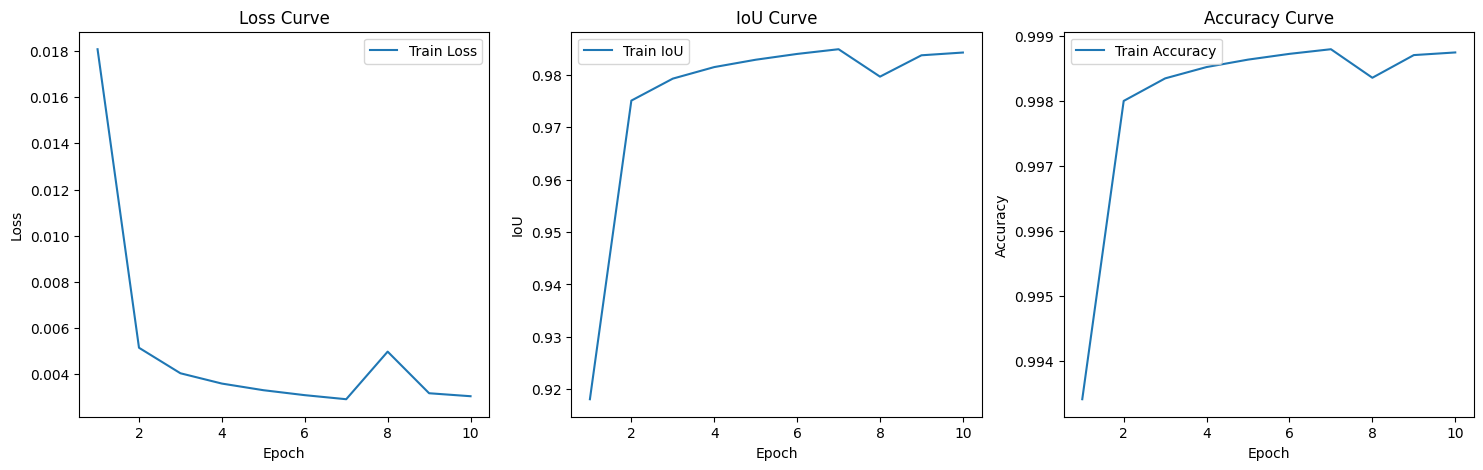

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def calculate_iou(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = intersection / union if union > 0 else torch.tensor(1.0)
    return iou.item()

def calculate_accuracy(pred, target):
    pred = (pred > 0.5).float()  # Бинаризуем предсказания
    correct = (pred == target).sum()
    total = target.numel()  # Общее количество пикселей
    accuracy = correct / total
    return accuracy.item()

def train_model(model, train_loader, num_epochs=10, lr=0.001, device="cuda"):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()  # Используем BCE с логитами
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, train_ious, train_accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss, epoch_iou, epoch_accuracy = 0, 0, 0

        for i, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device).unsqueeze(1).float()  # Добавляем канал и приводим к float
        
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            iou = calculate_iou(outputs.sigmoid(), masks)
            accuracy = calculate_accuracy(outputs.sigmoid(), masks)

            epoch_loss += loss.item()
            epoch_iou += iou
            epoch_accuracy += accuracy

            if i % 10 == 0:
                print(f"[Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(train_loader)}] Loss: {loss.item():.4f}, IoU: {iou:.4f}, Accuracy: {accuracy:.4f}")

        train_losses.append(epoch_loss / len(train_loader))
        train_ious.append(epoch_iou / len(train_loader))
        train_accuracies.append(epoch_accuracy / len(train_loader))

        print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train IoU={train_ious[-1]:.4f}, Train Accuracy={train_accuracies[-1]:.4f}")

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(range(1, num_epochs+1), train_ious, label="Train IoU")
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.title("IoU Curve")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.show()

    torch.save(model.state_dict(), "u-net-minerals-creative-15k.pth")

num_epochs = 10
learning_rate = 1e-4

train_model(model, train_loader, num_epochs=num_epochs, lr=learning_rate, device="cuda")


In [15]:
torch.save(model.state_dict(), "u-net-mineralscreative15k.pth")

In [15]:
device='cuda'
model.load_state_dict(torch.load("/kaggle/working/u-net-mineralscreative15k.pth"))
model.to(device)
model.eval()

<ipython-input-15-fdf7772aa4c6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/u-net-mineralscreative15k.pth"))


UNetWithDeepLabEncoder(
  (encoder): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (dow

In [30]:
import os
import shutil

src_masks_dir = "/kaggle/input/minerals-creative-15kgenerated/minerals-creative-15k/annotations/test"

dst_masks_dir = "/kaggle/working/cleaned_masks"
os.makedirs(dst_masks_dir, exist_ok=True)  # Создаём, если нет

# Копируем файлы с исправленными именами
for filename in os.listdir(src_masks_dir):
    old_path = os.path.join(src_masks_dir, filename)

    if os.path.isfile(old_path):
        # Убираем всё, что идёт после первого пробела
        new_filename = filename.split(" ")[0] + ".png"
        new_path = os.path.join(dst_masks_dir, new_filename)

        # Копируем файл с новым именем
        shutil.copy2(old_path, new_path)
        print(f"✅ {filename} → {new_filename}")

print("🎯 Копирование завершено! Теперь используй", dst_masks_dir)


✅ bg_3_combo_2310 23.03.50.png → bg_3_combo_2310.png
✅ bg_1_combo_2285 23.03.46.png → bg_1_combo_2285.png
✅ bg_3_combo_2457 23.03.52.png → bg_3_combo_2457.png
✅ bg_5_combo_2254 23.03.54.png → bg_5_combo_2254.png
✅ bg_5_combo_2327 23.03.55.png → bg_5_combo_2327.png
✅ bg_0_combo_2483 23.03.46.png → bg_0_combo_2483.png
✅ bg_5_combo_2351 23.03.55.png → bg_5_combo_2351.png
✅ bg_2_combo_2418 23.03.49.png → bg_2_combo_2418.png
✅ bg_4_combo_2347 23.03.53.png → bg_4_combo_2347.png
✅ bg_1_combo_2348 23.03.47.png → bg_1_combo_2348.png
✅ bg_2_combo_2432 23.03.49.png → bg_2_combo_2432.png
✅ bg_1_combo_2466 23.03.48.png → bg_1_combo_2466.png
✅ bg_3_combo_2400 23.03.51.png → bg_3_combo_2400.png
✅ bg_5_combo_2427 23.03.56.png → bg_5_combo_2427.png
✅ bg_1_combo_2499 23.03.48.png → bg_1_combo_2499.png
✅ bg_3_combo_2363 23.03.51.png → bg_3_combo_2363.png
✅ bg_1_combo_2332 23.03.46.png → bg_1_combo_2332.png
✅ bg_3_combo_2281 23.03.50.png → bg_3_combo_2281.png
✅ bg_0_combo_2326 23.03.44.png → bg_0_combo_23

In [16]:
test_dataset = PlantSegDataset(test_images_path, "/kaggle/working/cleaned_masks", img_size=512)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, drop_last=True)

In [19]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

predictions = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)

        outputs = model(images)

        preds = (outputs.sigmoid() > 0.5).float()

        predictions.extend(preds.cpu().numpy())

print(f"Получены предсказания для {len(predictions)} изображений.")



Получены предсказания для 1500 изображений.


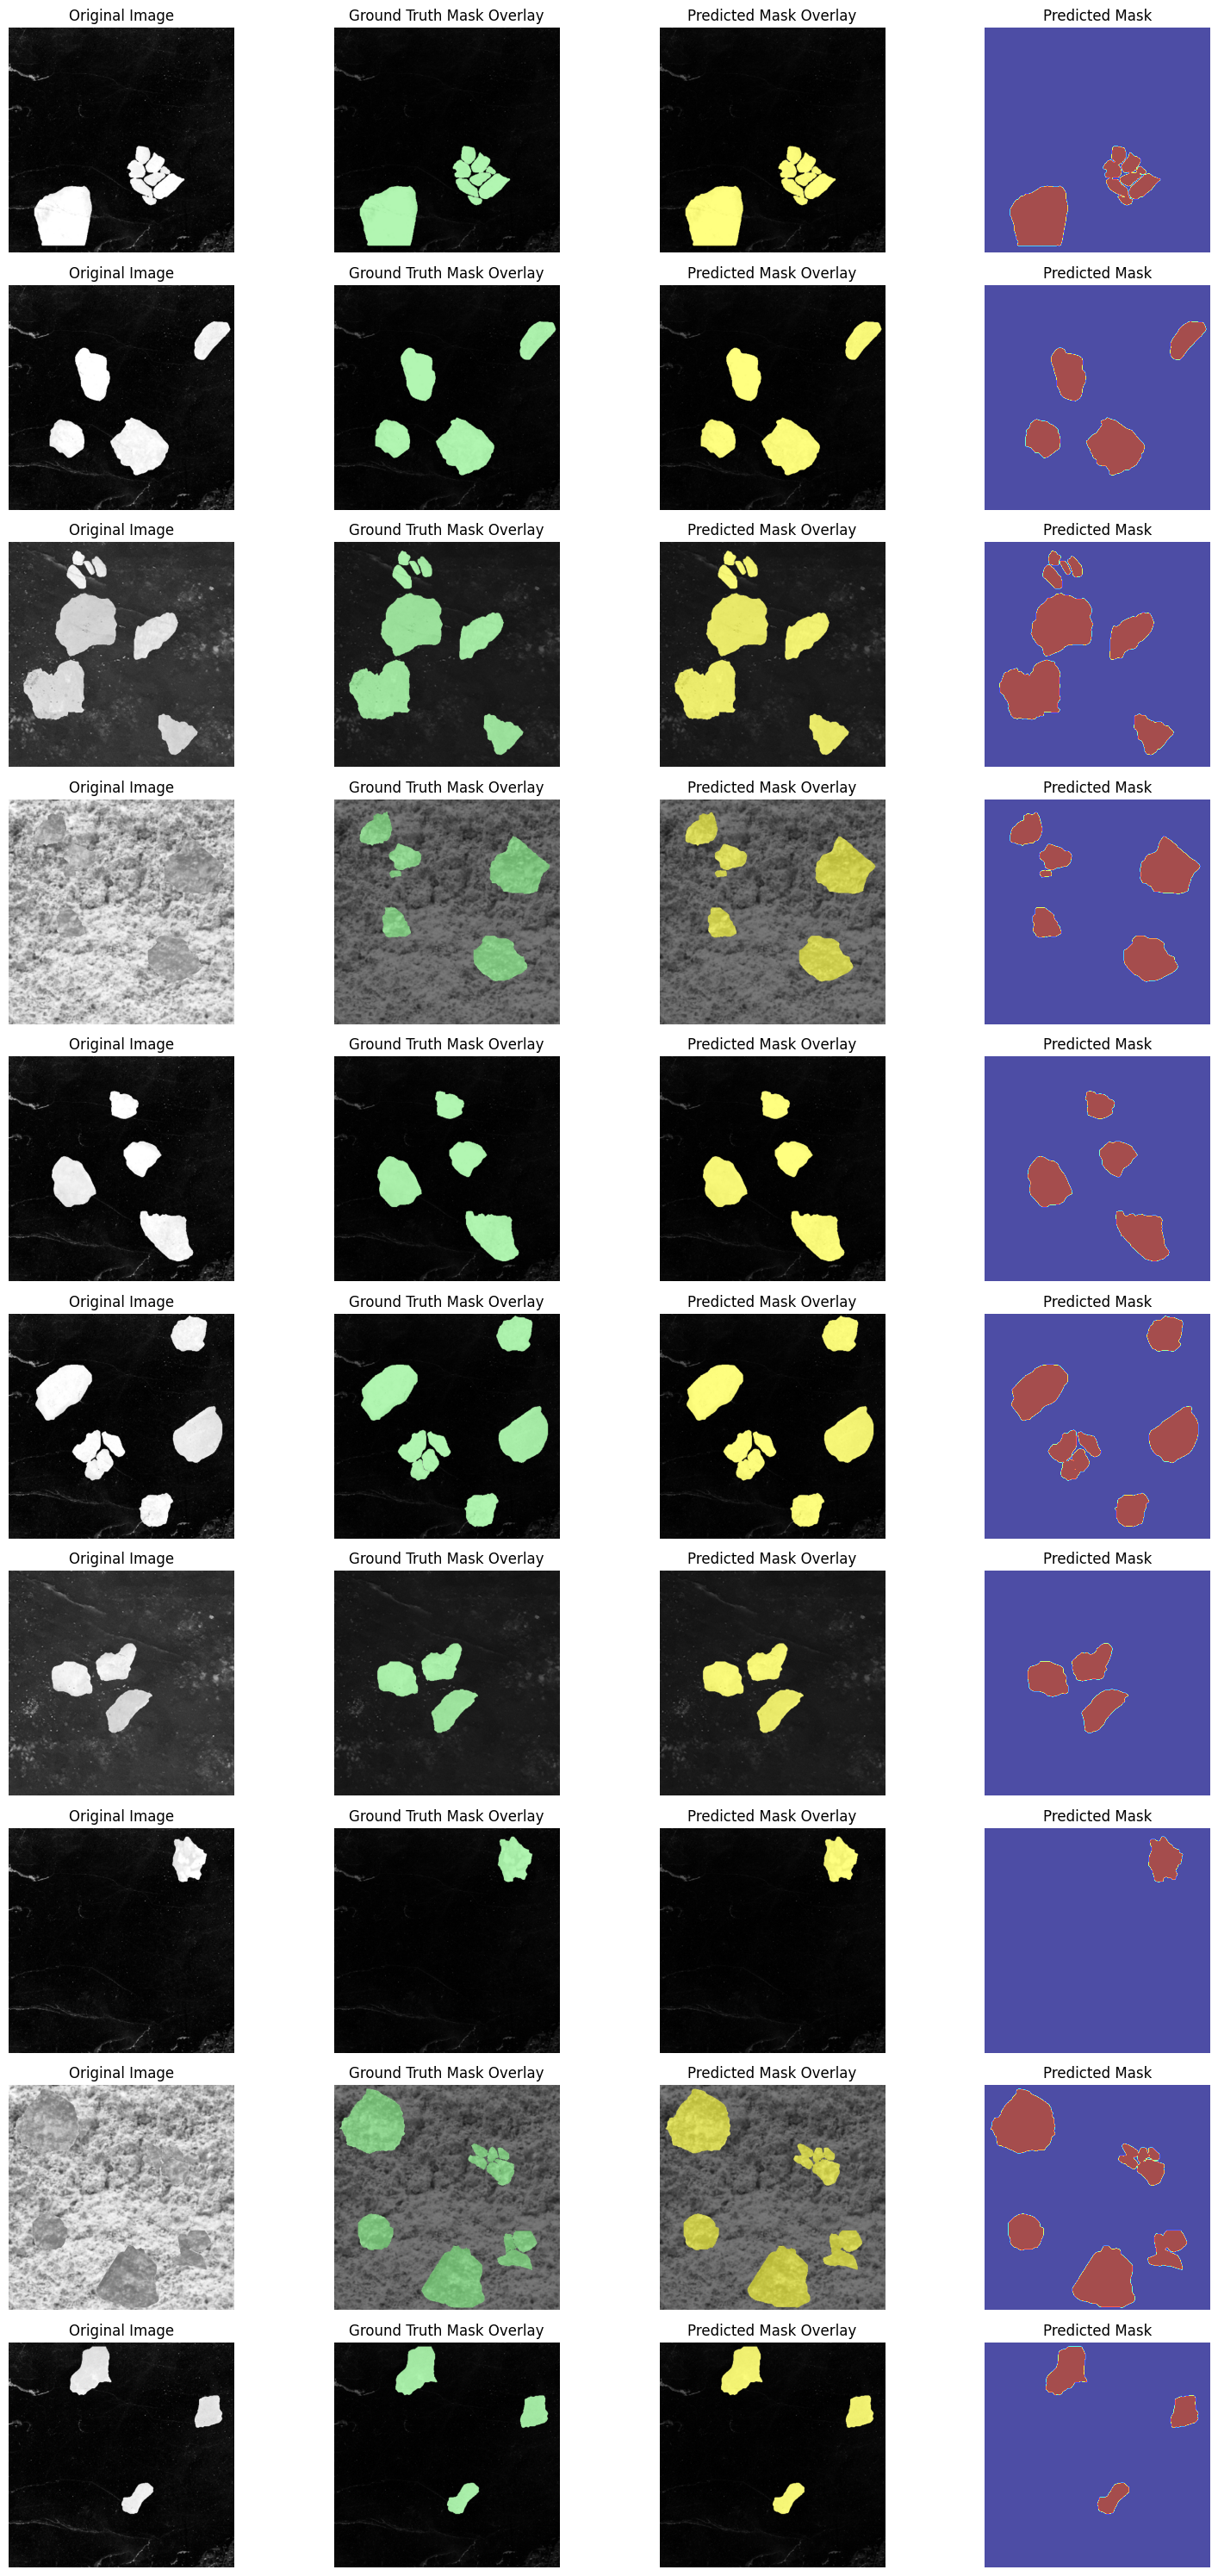

In [20]:
import random
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

def apply_mask(image, mask, color=(255, 0, 0), alpha=0.5):
    """Накладывает маску на изображение с прозрачностью."""
    colored_mask = np.zeros_like(image)
    for i in range(3):  
        colored_mask[:, :, i] = mask * color[i]
    
    return cv2.addWeighted(image, 1 - alpha, colored_mask, alpha, 0)

def visualize_predictions(test_loader, predictions, num_samples=10):
    """Визуализирует предсказания модели с наложением масок."""
    samples = random.sample(range(len(predictions)), num_samples)
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 3))
    
    for i, idx in enumerate(samples):
        image, mask = test_loader.dataset[idx]
        image = image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
        mask = mask.numpy()
        pred_mask = predictions[idx].squeeze(0)

        image_vis = (image * 255).astype(np.uint8)

        overlay_pred = apply_mask(image_vis, pred_mask, color=(255, 255, 0), alpha=0.5)
        overlay_gt = apply_mask(image_vis, mask, color=(100, 238, 100), alpha=0.5)

        axes[i, 0].imshow(image_vis)
        axes[i, 0].set_title("Original Image")
        
        axes[i, 1].imshow(overlay_gt)
        axes[i, 1].set_title("Ground Truth Mask Overlay")
        
        axes[i, 2].imshow(overlay_pred)
        axes[i, 2].set_title("Predicted Mask Overlay")
        
        axes[i, 3].imshow(pred_mask, cmap='jet', alpha=0.7)
        axes[i, 3].set_title("Predicted Mask")
        
        for ax in axes[i]:
            ax.axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_predictions(test_loader, predictions, num_samples=10)


In [26]:
import numpy as np
import torch

def calculate_iou(preds, labels, num_classes):
    """
    Функция для расчета IoU для всех классов.
    """
    iou_per_class = []
    for i in range(num_classes):
        intersection = ((preds == i) & (labels == i)).sum().item()
        union = ((preds == i) | (labels == i)).sum().item()
        iou = intersection / union if union != 0 else float('nan')
        iou_per_class.append(iou)
        
    return np.nanmean(iou_per_class)

def calculate_accuracy(preds, labels, threshold=0.5):
    """
    Рассчитывает точность (Accuracy) как процент правильно предсказанных пикселей.
    """
    preds = preds.squeeze(1)
    
    preds = (preds > threshold).long()
    labels = (labels > threshold).long()

    correct = (preds == labels).sum().item()
    total = labels.numel()

    return correct / total if total > 0 else 0.0




test_ious = []
test_accuracies = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        logits = model(images)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        masks = (masks > 0.5).long()

        # IoU
        iou_batch = calculate_iou(preds, masks, num_classes=1)
        test_ious.append(iou_batch)

        # Accuracy
        acc = calculate_accuracy(preds, masks)
        test_accuracies.append(acc)

mean_iou = np.nanmean(test_ious)
mean_accuracy = np.mean(test_accuracies)

print(f"Средний IoU на тестовой выборке: {mean_iou:.4f}")
print(f"Средняя Accuracy на тестовой выборке: {mean_accuracy:.4f}")


Средний IoU на тестовой выборке: 0.8909
Средняя Accuracy на тестовой выборке: 0.9987


In [27]:
import numpy as np
import torch

def dice_score(preds, masks, num_classes):
    """
    Функция для расчета Dice Score для всех классов.
    """
    preds = preds.squeeze(1)
    preds = preds.cpu().numpy()
    masks = masks.cpu().numpy()

    dice_per_class = np.zeros(num_classes)

    for i in range(num_classes):
        intersection = np.logical_and(preds == i, masks == i).sum()
        union = (preds == i).sum() + (masks == i).sum()

        if union > 0:
            dice_per_class[i] = (2 * intersection) / union
    
    mean_dice = np.mean(dice_per_class[dice_per_class > 0]) if np.any(dice_per_class > 0) else 0.0
    return dice_per_class, mean_dice


test_dices = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        logits = model(images)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        _, mean_dice = dice_score(preds, masks, num_classes=2)
        test_dices.append(mean_dice)

mean_dice_score = np.mean(test_dices)

print(f"Средний Dice Score на тестовой выборке: {mean_dice_score:.4f}")

Средний Dice Score на тестовой выборке: 0.9957


In [28]:
from sklearn.metrics import precision_recall_curve, auc

def calculate_map(preds, masks):
    """
    Функция для вычисления mAP для бинарной сегментации (1 класс).
    """
    preds = preds.cpu().numpy()
    masks = masks.cpu().numpy()

    y_true = (masks == 1).astype(np.uint8).flatten()
    y_pred = (preds == 1).astype(np.uint8).flatten()

    if np.sum(y_true) == 0:
        return 0.0

    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    ap = auc(recall, precision)

    return ap

test_map_scores = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)


        logits = model(images)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        mean_ap = calculate_map(preds, masks)
        test_map_scores.append(mean_ap)

mean_map = np.mean(test_map_scores)

print(f"Средний mAP на тестовой выборке: {mean_map:.4f}")


Средний mAP на тестовой выборке: 0.9924


In [32]:
dataset_path = "/kaggle/input/mineralvision/MineralVision.v4i.coco"
test_images_path = os.path.join(dataset_path, "images/test")
test_masks_path = os.path.join(dataset_path, "annotations/test")

print("Test Images:", len(os.listdir(test_images_path)))
print("Test Masks:", len(os.listdir(test_masks_path)))

Test Images: 120
Test Masks: 120


In [34]:
test_dataset = PlantSegDataset(test_images_path, test_masks_path, img_size=512)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, drop_last=True)

In [35]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

predictions = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)

        outputs = model(images)

        preds = (outputs.sigmoid() > 0.5).float()

        predictions.extend(preds.cpu().numpy())

print(f"Получены предсказания для {len(predictions)} изображений.")



Получены предсказания для 120 изображений.


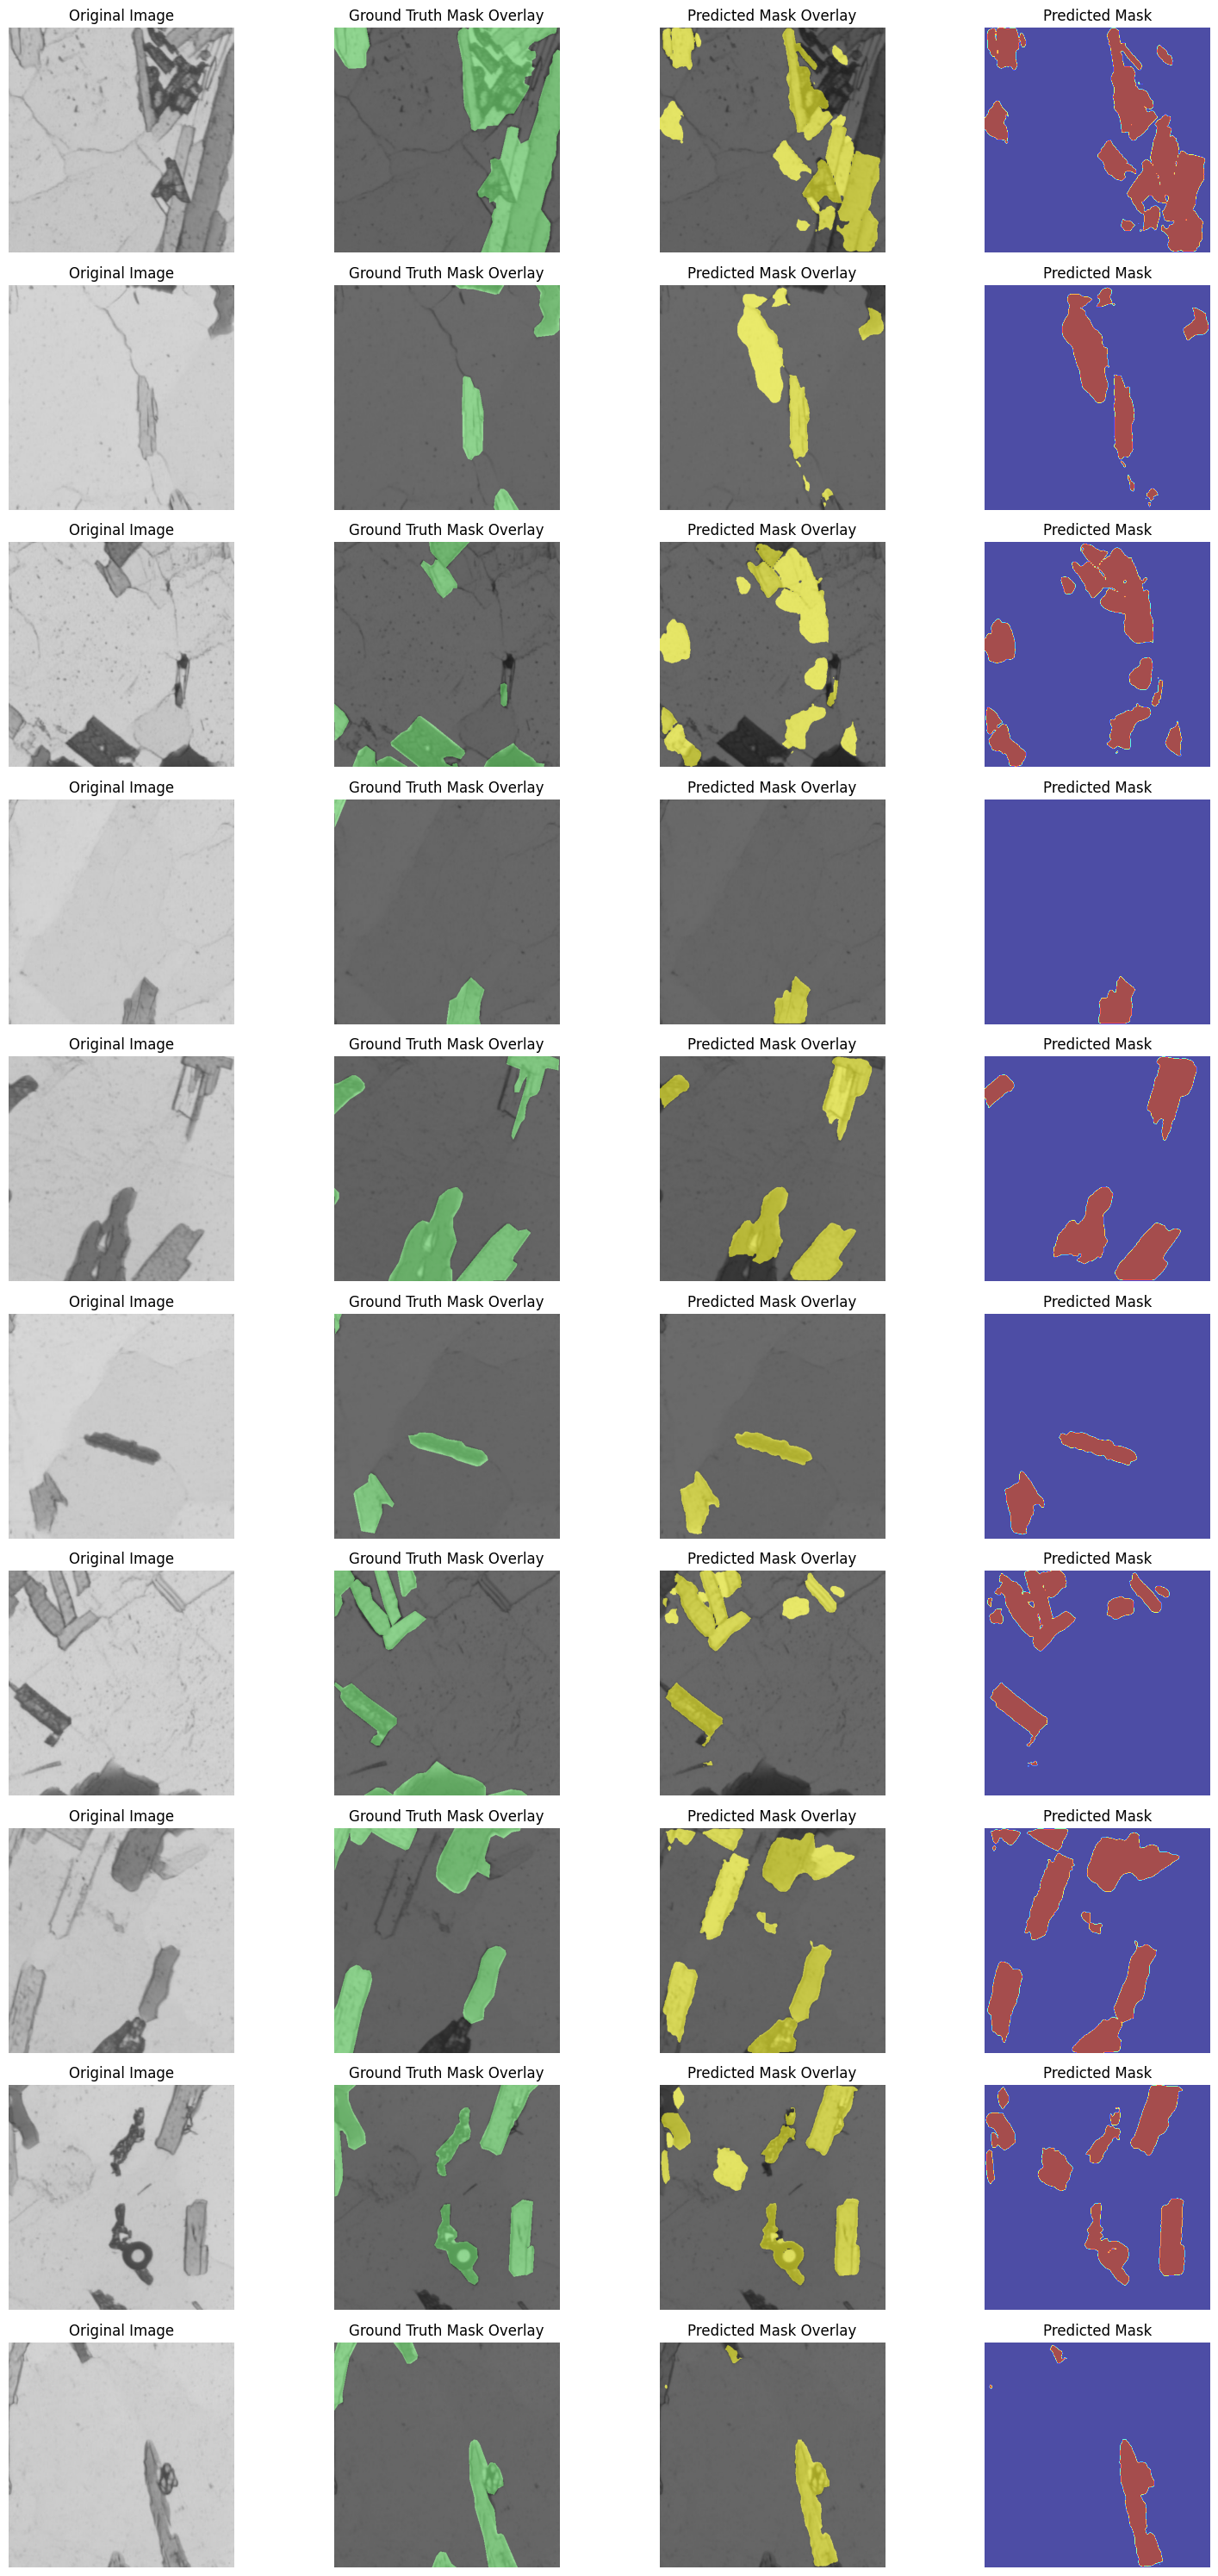

In [36]:
import random
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

def apply_mask(image, mask, color=(255, 0, 0), alpha=0.5):
    colored_mask = np.zeros_like(image)
    for i in range(3):  
        colored_mask[:, :, i] = mask * color[i]
    
    return cv2.addWeighted(image, 1 - alpha, colored_mask, alpha, 0)

def visualize_predictions(test_loader, predictions, num_samples=10):
    samples = random.sample(range(len(predictions)), num_samples)
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 3))
    
    for i, idx in enumerate(samples):
        image, mask = test_loader.dataset[idx]
        image = image.numpy().transpose(1, 2, 0)
        mask = mask.numpy()
        pred_mask = predictions[idx].squeeze(0)

        image_vis = (image * 255).astype(np.uint8)

        overlay_pred = apply_mask(image_vis, pred_mask, color=(255, 255, 0), alpha=0.5)
        overlay_gt = apply_mask(image_vis, mask, color=(100, 238, 100), alpha=0.5)

        axes[i, 0].imshow(image_vis)
        axes[i, 0].set_title("Original Image")
        
        axes[i, 1].imshow(overlay_gt)
        axes[i, 1].set_title("Ground Truth Mask Overlay")
        
        axes[i, 2].imshow(overlay_pred)
        axes[i, 2].set_title("Predicted Mask Overlay")
        
        axes[i, 3].imshow(pred_mask, cmap='jet', alpha=0.7)
        axes[i, 3].set_title("Predicted Mask")
        
        for ax in axes[i]:
            ax.axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_predictions(test_loader, predictions, num_samples=10)


In [37]:
import numpy as np
import torch

def calculate_iou(preds, labels, num_classes):
    iou_per_class = []
    for i in range(num_classes):
        intersection = ((preds == i) & (labels == i)).sum().item()
        union = ((preds == i) | (labels == i)).sum().item()
        iou = intersection / union if union != 0 else float('nan')
        iou_per_class.append(iou)
        
    return np.nanmean(iou_per_class)

def calculate_accuracy(preds, labels, threshold=0.5):
    preds = preds.squeeze(1)
    
    preds = (preds > threshold).long()
    labels = (labels > threshold).long()

    correct = (preds == labels).sum().item()
    total = labels.numel()

    return correct / total if total > 0 else 0.0


test_ious = []
test_accuracies = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        logits = model(images)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        masks = (masks > 0.5).long()

        iou_batch = calculate_iou(preds, masks, num_classes=1)
        test_ious.append(iou_batch)

        acc = calculate_accuracy(preds, masks)
        test_accuracies.append(acc)

mean_iou = np.nanmean(test_ious)
mean_accuracy = np.mean(test_accuracies)

print(f"Средний IoU на тестовой выборке: {mean_iou:.4f}")
print(f"Средняя Accuracy на тестовой выборке: {mean_accuracy:.4f}")


Средний IoU на тестовой выборке: 0.8362
Средняя Accuracy на тестовой выборке: 0.9327


In [38]:
import numpy as np
import torch

def dice_score(preds, masks, num_classes):

    preds = preds.squeeze(1)
    preds = preds.cpu().numpy()
    masks = masks.cpu().numpy()

    dice_per_class = np.zeros(num_classes)

    for i in range(num_classes):
        intersection = np.logical_and(preds == i, masks == i).sum()
        union = (preds == i).sum() + (masks == i).sum()

        if union > 0:
            dice_per_class[i] = (2 * intersection) / union
    
    mean_dice = np.mean(dice_per_class[dice_per_class > 0]) if np.any(dice_per_class > 0) else 0.0
    return dice_per_class, mean_dice


test_dices = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        logits = model(images)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        _, mean_dice = dice_score(preds, masks, num_classes=2)
        test_dices.append(mean_dice)

mean_dice_score = np.mean(test_dices)

print(f"Средний Dice Score на тестовой выборке: {mean_dice_score:.4f}")

Средний Dice Score на тестовой выборке: 0.8310


In [39]:
from sklearn.metrics import precision_recall_curve, auc

def calculate_map(preds, masks):

    preds = preds.cpu().numpy()
    masks = masks.cpu().numpy()

    y_true = (masks == 1).astype(np.uint8).flatten()
    y_pred = (preds == 1).astype(np.uint8).flatten()

    if np.sum(y_true) == 0:
        return 0.0

    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    ap = auc(recall, precision)

    return ap

test_map_scores = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        logits = model(images)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        mean_ap = calculate_map(preds, masks)
        test_map_scores.append(mean_ap)

mean_map = np.mean(test_map_scores)

print(f"Средний mAP на тестовой выборке: {mean_map:.4f}")


Средний mAP на тестовой выборке: 0.7196
